In [ ]:
!pip install yahoo_fin

In [1]:
from datetime import date
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import numpy as np
import yahoo_fin.stock_info as si

In [ ]:
# 有名な株価指数の構成銘柄を取得

si.tickers_dow()     # NYダウ
si.tickers_nasdaq()  # ナスダック
si.tickers_sp500()   # S&P500

In [17]:
# S&P500 構成銘柄をwikipediaから取得
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

sp500 = pd.read_html(url)[0]

# 不要なカラム削除
sp500.drop(['SEC filings', 'GICS Sub-Industry', 'Headquarters Location', 'Date first added', 'CIK', 'Founded'], axis=1, inplace=True)
sp500

,Symbol,Security,GICS Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care
...,...,...,...
500,YUM,Yum! Brands,Consumer Discretionary
501,ZBRA,Zebra Technologies,Information Technology
502,ZBH,Zimmer Biomet,Health Care
503,ZION,Zions Bancorp,Financials


In [18]:
# セクターリストの作成
sector_list = sp500['GICS Sector'].value_counts().index
sector_list

Index(['Information Technology', 'Industrials', 'Financials', 'Health Care',
       'Consumer Discretionary', 'Consumer Staples', 'Real Estate',
       'Materials', 'Utilities', 'Communication Services', 'Energy'],
      dtype='object')

In [178]:
# 時価総額の追加
sp500['Market Cap'] = np.zeros(len(sp500))

count = 1
for ticker in sp500['Symbol']:
    print('Count: ', count)
    count += 1
    try:
        market_cap = si.get_quote_table(ticker)['Market Cap']
        char = market_cap[-1]

        unit = 0
        if char == 'M':
            unit = 1000000
        elif char == 'B':
            unit = 1000000000
        elif char == 'T':
            unit = 1000000000000
        sp500.loc[sp500['Symbol']==ticker, ['Market Cap']] = float(market_cap[:-1]) * unit
        # https://qiita.com/FukuharaYohei/items/b3aa7113d08858676910
    except Exception as e:
        print(f'{ticker} is error!!!\n')
        import traceback
        traceback.print_exc()

sp500.to_csv('csv/sp500_df.csv', index=False)

NameError: name 'sp500' is not defined

In [166]:
sp500_df = pd.read_csv('csv/sp500_df.csv', index_col=[0])
sector_list = sp500_df['GICS Sector'].value_counts().index

# 各セクターのTOP10のみを抽出
sp500_top10_df = pd.DataFrame(columns=['Security', 'GICS Sector', 'Market Cap'])
sp500_top10_df.index.name = 'Symbol'

for sector in sector_list:
    sort_df = sp500_df.loc[sp500_df['GICS Sector']==sector, :].sort_values(by=['Market Cap'], ascending=False)[:10]
    sp500_top10_df = pd.concat([sp500_top10_df, sort_df])
sp500_top10_df

,Security,GICS Sector,Market Cap
Symbol,,,
AAPL,Apple,Information Technology,2.850000e+12
MSFT,Microsoft,Information Technology,2.350000e+12
NVDA,Nvidia,Information Technology,6.314480e+11
V,Visa,Information Technology,5.070180e+11
MA,Mastercard,Information Technology,3.877360e+11
...,...,...,...
PXD,Pioneer Natural Resources,Energy,5.346500e+10
MPC,Marathon Petroleum,Energy,4.730800e+10
KMI,Kinder Morgan,Energy,3.946500e+10


In [86]:
# Information Technologyのcloseデータを取得
it_top10 = sp500_top10_df[sp500_top10_df['GICS Sector']=='Information Technology'].index.values
it_top10_closes = {}
for ticker in it_top10:
    it_top10_closes[ticker] = si.get_data(ticker, start_date='2018-01-01')['close']
it_top10_closes

AAPL
MSFT
NVDA
V
MA
ADBE
AVGO
CSCO
CRM
ACN


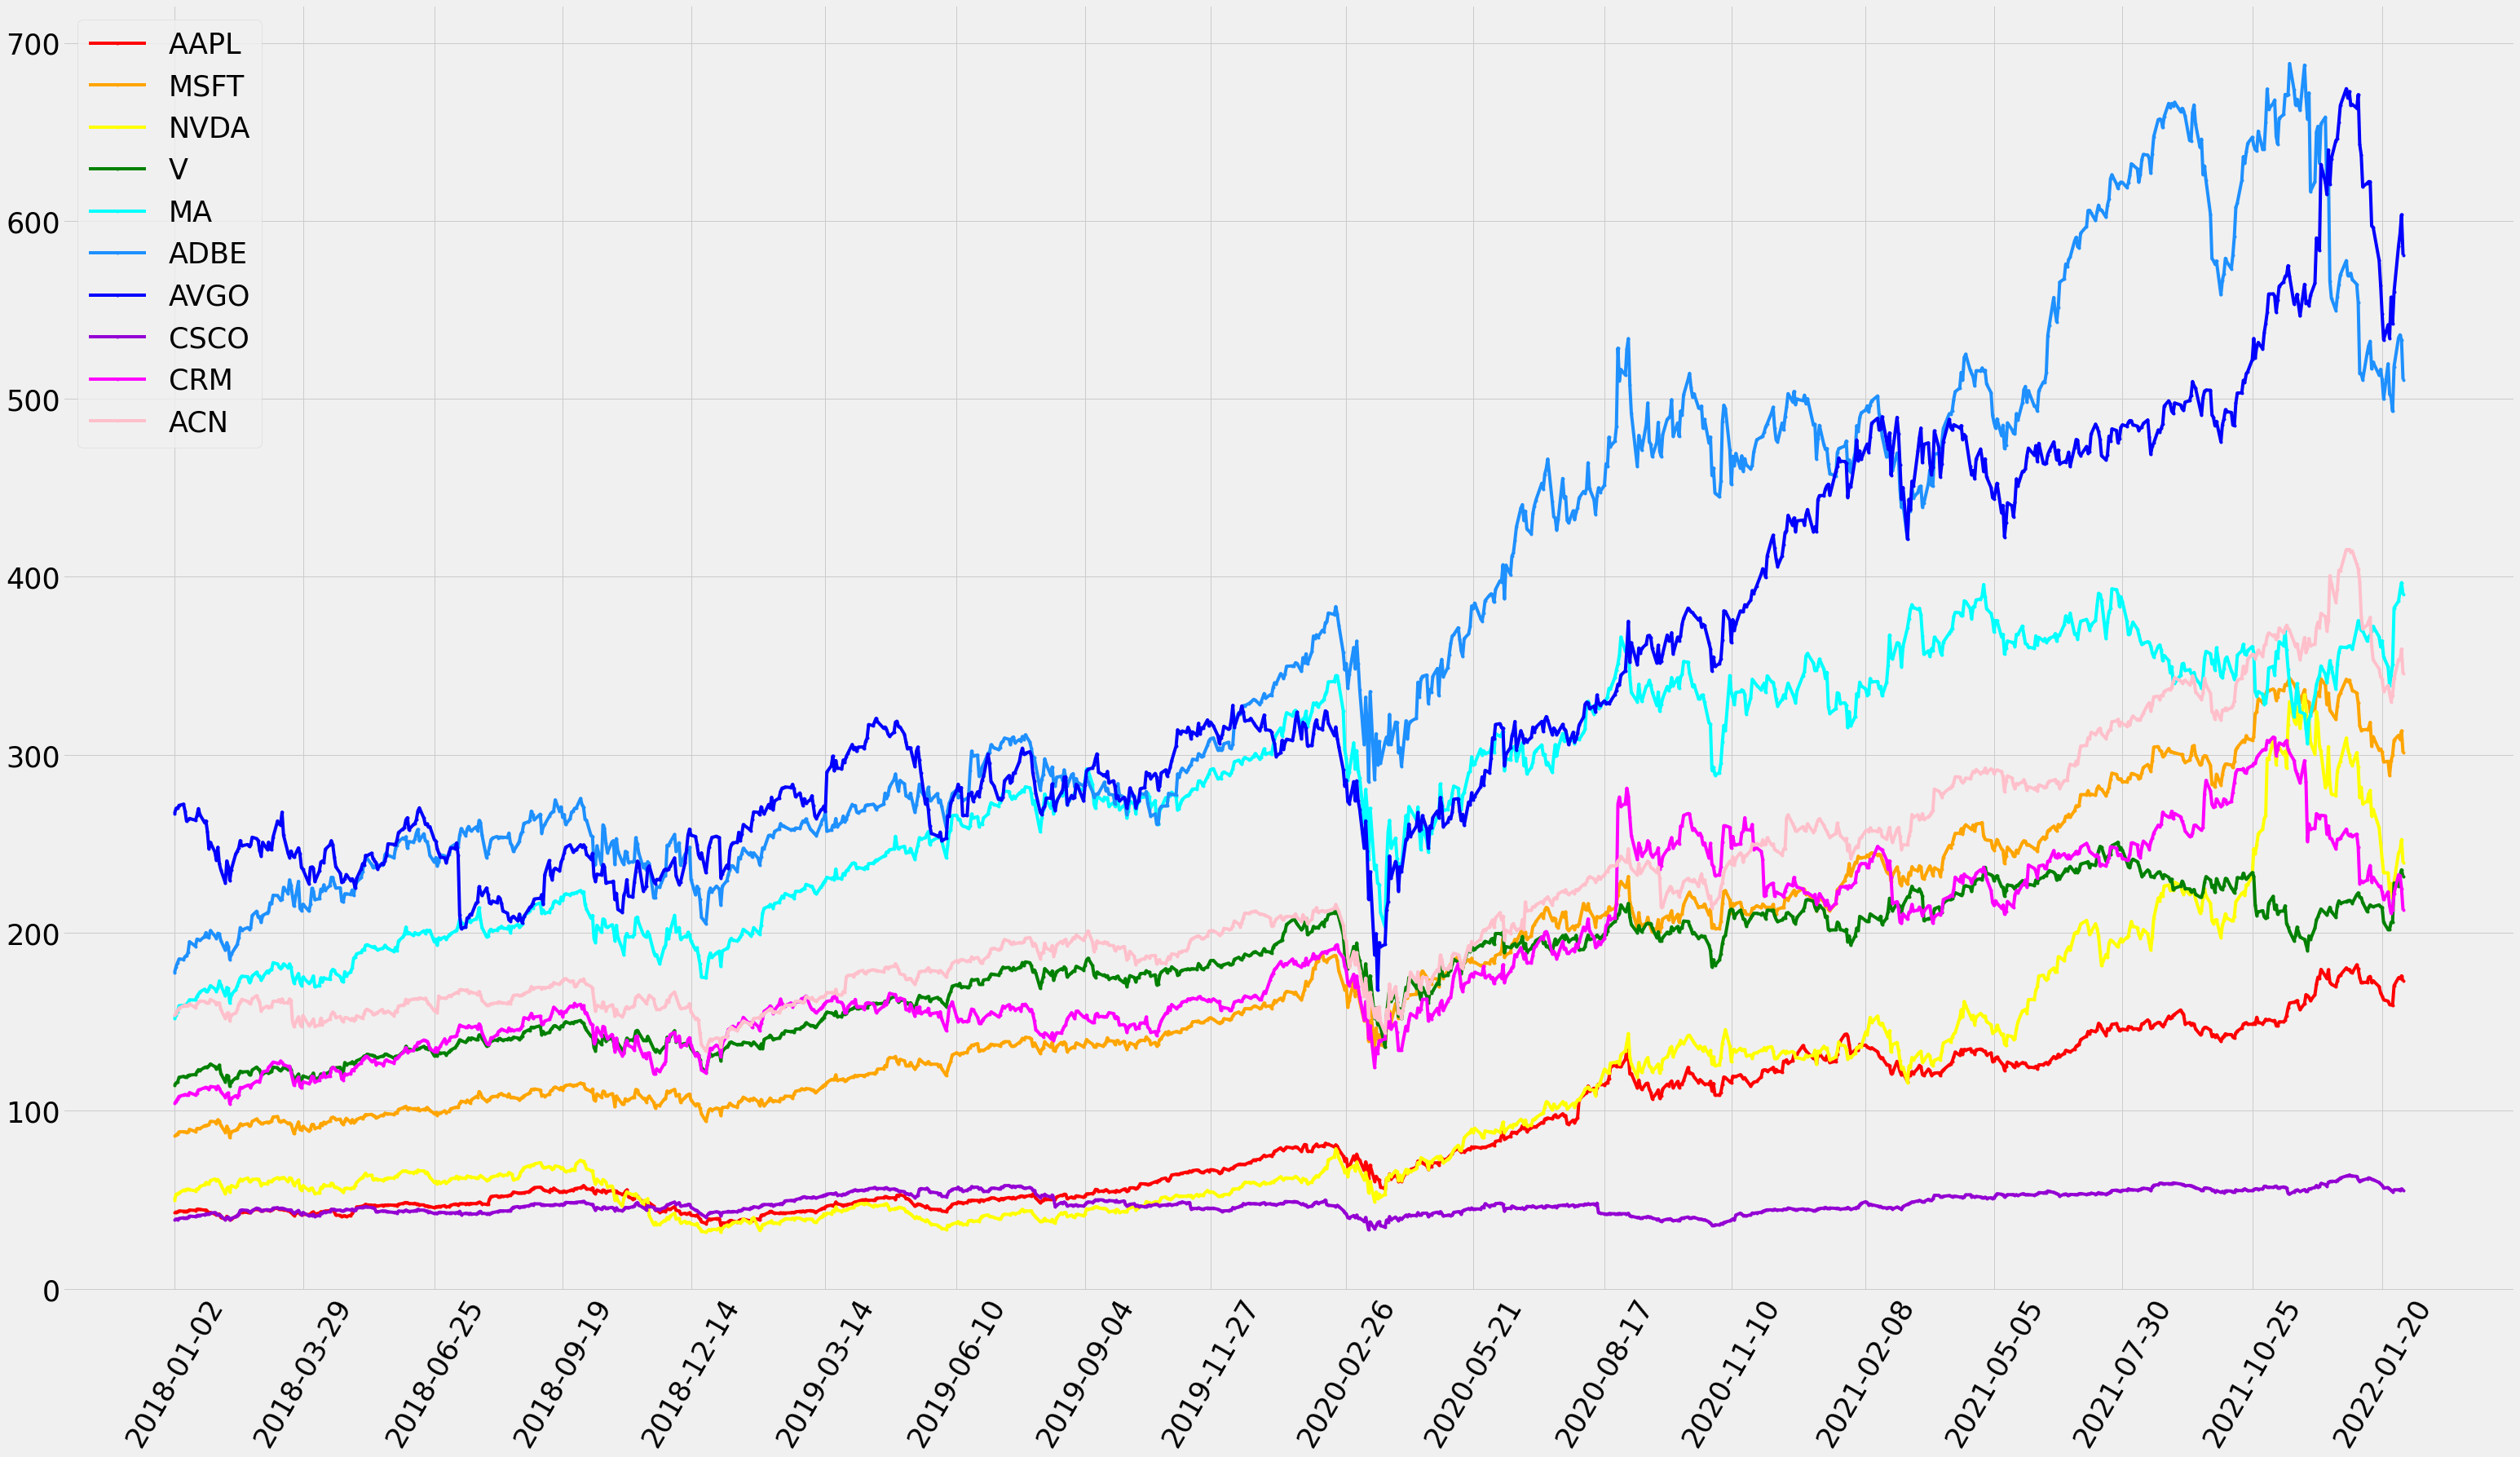

In [88]:
# 値動きを表示
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [48, 30]
plt.rcParams['figure.subplot.bottom'] = 0.15
fig = plt.figure()

color_list = ['red', 'orange', 'yellow', 'green', 'cyan', 'dodgerblue', 'blue', 'darkviolet', 'fuchsia', 'pink']
for i, ticker in enumerate(it_top10_closes.keys()):
    plt.plot(it_top10_closes[ticker], marker='.', color=color_list[i])
    plt.xticks([str(it_top10_closes[ticker].index[i])[:10] for i in range(0, len(it_top10_closes[ticker]), 60)], fontsize=35, rotation=60)
    plt.yticks(fontsize=35)
plt.legend([key for key in it_top10_closes.keys()], fontsize=35)
plt.show()

In [ ]:
# 今と10年前の株価を取得

In [167]:
# 取得対象の日付を設定
date_format = '%Y-%m-%d'

today = date.today()
ago_7d = (today + relativedelta(days=-7)).strftime(date_format)

ago_10y = (today + relativedelta(years=-10))
ago_10y_7d = (ago_10y + relativedelta(days=-7)).strftime(date_format)

today = today.strftime(date_format)
ago_10y = ago_10y.strftime(date_format)

# カラムを追加
sp500_top10_df['Today Price'] = np.zeros(len(sp500_top10_df))
sp500_top10_df['10 Years Ago Price'] = np.zeros(len(sp500_top10_df))

In [168]:
for ticker in sp500_top10_df.index:
    try:
        sp500_top10_df.loc[ticker, 'Today Price'] = si.get_data(ticker, start_date=ago_7d, end_date=today).dropna(axis=0).iloc[-1, 3]
        sp500_top10_df.loc[ticker, '10 Years Ago Price'] = si.get_data(ticker, start_date=ago_10y_7d, end_date=ago_10y).dropna(axis=0).iloc[-1, 3]
    except Exception:
        continue
sp500_top10_df.to_csv('csv/sp500_top10_df.csv')

In [2]:
sp500_top10_df = pd.read_csv('csv/sp500_top10_df.csv', index_col=[0])
sp500_top10_df

,Security,GICS Sector,Market Cap,Today Price,10 Years Ago Price
Symbol,,,,,
AAPL,Apple,Information Technology,2.850000e+12,175.839996,16.417143
MSFT,Microsoft,Information Technology,2.350000e+12,313.459991,30.240000
NVDA,Nvidia,Information Technology,6.314480e+11,252.419998,3.955000
V,Visa,Information Technology,5.070180e+11,235.419998,26.757500
MA,Mastercard,Information Technology,3.877360e+11,396.750000,39.032001
...,...,...,...,...,...
PXD,Pioneer Natural Resources,Energy,5.346500e+10,223.479996,104.389999
MPC,Marathon Petroleum,Energy,4.730800e+10,78.500000,21.990000
KMI,Kinder Morgan,Energy,3.946500e+10,17.410000,31.920000


In [65]:
df = pd.DataFrame()

for sector in sp500_top10_df['GICS Sector'].value_counts().index:
    df[sector] = (sp500_top10_df.loc[sp500_top10_df['GICS Sector']==sector]['Today Price'] / sp500_top10_df.loc[sp500_top10_df['GICS Sector']==sector]['10 Years Ago Price']).T.values

df.set_axis(np.arange(1, 11), axis='index', inplace=True)
df.index.name = 'Market Cap Rank'
df

,Utilities,Financials,Health Care,Industrials,Communication Services,Real Estate,Energy,Consumer Staples,Materials,Information Technology,Consumer Discretionary
Market Cap Rank,,,,,,,,,,,
1,5.163927,3.916928,2.632084,3.026206,9.917462,4.744572,0.949364,2.270676,2.983614,10.710755,16.049926
2,1.635514,5.980867,9.350614,4.327965,9.967057,3.982010,1.283507,2.590410,9.030991,10.365741,145.370782
3,1.553273,1.825988,2.677757,3.584154,inf,3.738318,1.716722,1.797297,3.400247,63.823010,8.273855
4,1.614133,5.116691,inf,1.814264,3.565500,5.769788,2.070217,2.632313,0.847461,8.798281,5.747247
5,2.270844,7.053864,10.732457,2.718365,3.682505,2.620348,0.498983,6.115511,3.128230,10.164736,2.622538
6,2.370497,3.524593,6.348520,4.236199,1.421776,1.145907,2.140818,1.356043,1.018030,16.737520,8.790809
7,1.512833,1.974657,4.927811,1.798666,23.778851,2.087133,3.569804,5.552714,inf,17.177056,4.045116
8,2.624057,4.360210,2.239940,0.670095,0.819366,1.931196,0.545426,1.746399,1.627015,2.795918,4.173571
9,2.222663,3.089084,7.345435,4.579028,5.804026,1.491475,inf,1.751040,3.455821,7.252538,4.462650


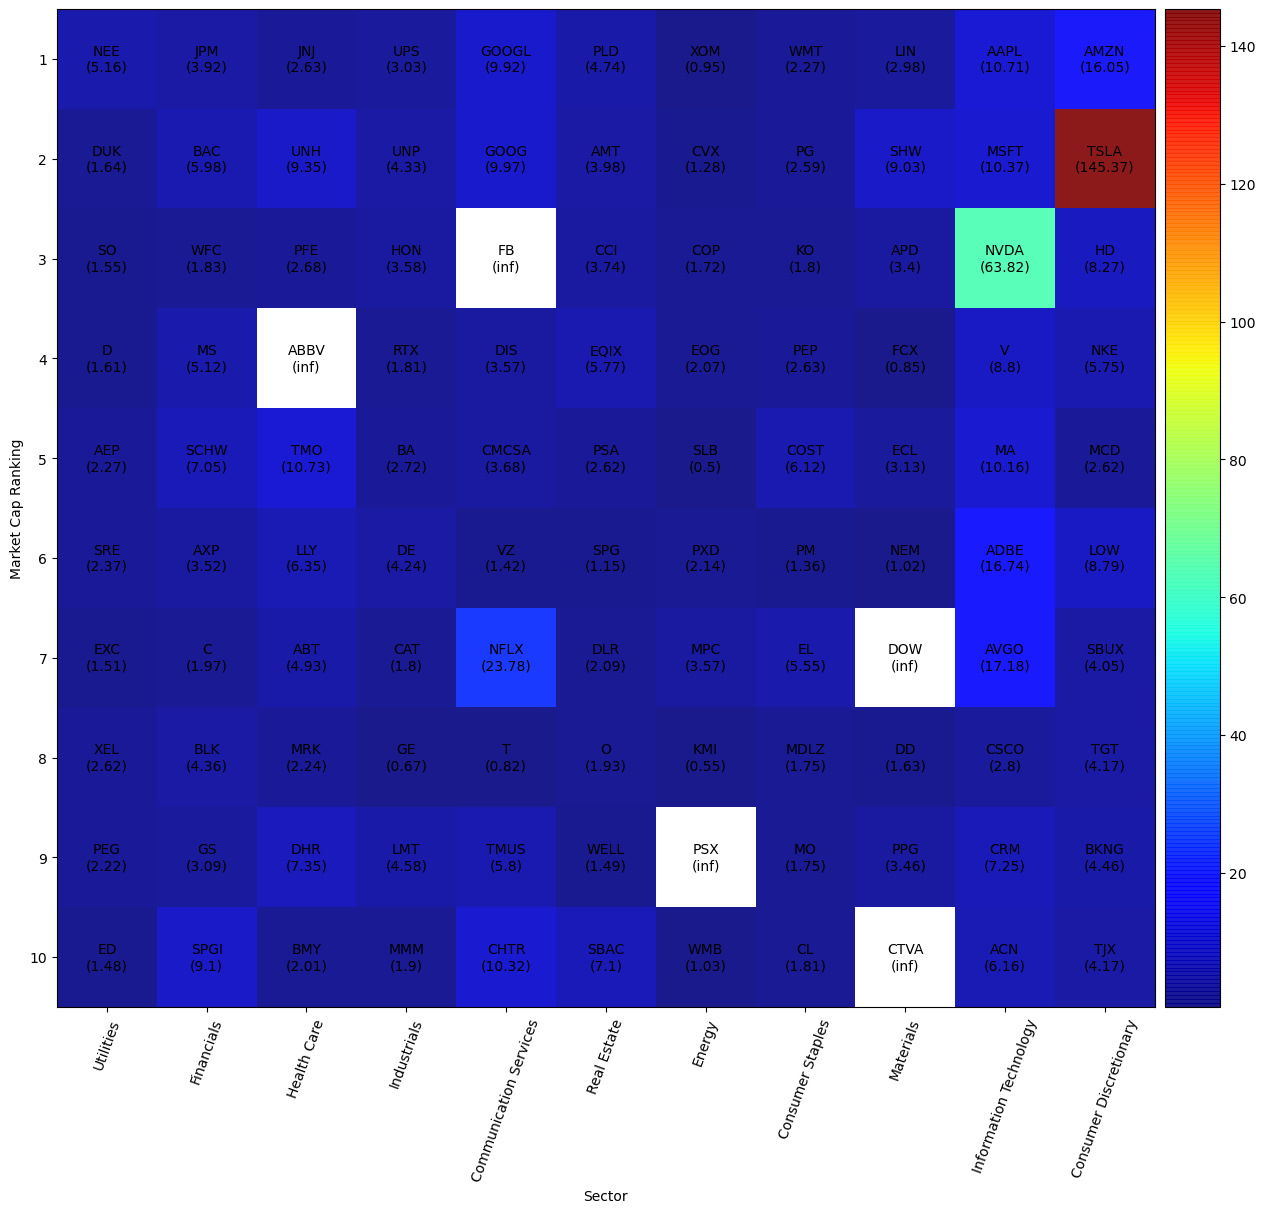

In [187]:
plt.style.use('default')

fig, ax = plt.subplots(figsize=(15, 15))
ax_img = ax.imshow(df, cmap='jet', interpolation='nearest', alpha=0.9)

for x, sector in enumerate(sp500_top10_df['GICS Sector'].value_counts().index):
    for y, symbol in enumerate(sp500_top10_df.loc[sp500_top10_df['GICS Sector']==sector].index):
        plt.text(x, y, f'{symbol}\n({round(df.iloc[y, x], 2)})', horizontalalignment='center', verticalalignment='center')

plt.xlabel('Sector')
plt.ylabel('Market Cap Ranking')
plt.xticks(range(0, 11), df.columns, rotation=70)
plt.yticks(range(0, 10), df.index)

divider = make_axes_locatable(ax) # axに紐付いたAxesDividerを取得
cax = divider.append_axes('right', size='5%', pad=0.1) # 新しいaxesを作成
plt.colorbar(ax_img, cax=cax) # 新しく作成したaxesであるcaxを渡す
plt.show()

fig.savefig('img/head_map.png', facecolor='white')